In [12]:
import torch
from utils import data_loader
from mnist_classifier import NeuralModel
import mnist_classifier
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pickle
from vae_models import VAE_CONV_NeuralModel
from utils.viewer import show_batch
import time 

In [13]:
train_set, test_set = data_loader.get_data()

batch_size = 1

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

epsilons = [0, .05, .1, .15, .2, .25, .3]
#epsilons = [0.3]
use_cuda = True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

classification_model = NeuralModel()
classification_model.to(device)
classification_model.load_state_dict(torch.load("models/trained_model"))
classification_model.eval()


NeuralModel(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
    (3): ReLU(inplace)
    (4): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(8, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1))
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): BatchNorm2d(8, eps=1e-05, momentum=0.5, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
  )
  (fc1): Linear(in_features=128, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=10, bias=True)
)

In [14]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [15]:
def test(model, device, test_loader, epsilon):
    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        if init_pred.item() != target.item():
            continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1]  # get the index of the max log-probability
        if final_pred.item() == target.item():
            correct += 1
            # Special case for saving 0 epsilon examples
            if (epsilon == 0) and (len(adv_examples) < 5):
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        else:
            # Save some adv examples for visualization later
            if len(adv_examples) < 10000:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

    # Calculate final accuracy for this epsilon
    final_acc = correct / float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [16]:
accuracies = []
examples = []

In [ ]:
#Run test for each epsilon
time_1 = time.time()
for eps in epsilons:
    acc, ex = test(classification_model, device, test_loader, eps)
    accuracies.append(acc)
    examples.append(ex)

# with open('models/adversarial_examples.pkl', 'wb') as f:
#     pickle.dump(examples, f)

In [ ]:
with open('models/adversarial_examples.pkl', 'rb') as f:
    examples = pickle.load(f)

examples = examples[0]

true_labels = []
adv_labels = []
images = []

for example in examples:
    true_label, adv_label, image = example

    true_labels.append(true_label)
    adv_labels.append(adv_label)
    images.append(image)

In [18]:
time_2 = time.time()

print("the time needed to perform the attacks is: ", time_2-time_1, " seconds")
# true_labels = torch.Tensor(true_labels).long()
# images = torch.Tensor(images)
# b_size, w, h = images.shape
# images = images.reshape(b_size, 1, w, h)

# vae = VAE_CONV_NeuralModel()
# vae.load_state_dict(torch.load("models/trained_CONV_vae_B=1"))
# #
# # plt.imshow(images[15])
# # plt.show()
# #

# testing_images = test_set.test_data.reshape(-1,1, 28,28).float()
# testing_labels = test_set.targets
# recs, _, _ = vae(testing_images)
# recs = recs.reshape(-1, 1, 28, 28)

# # show_batch(recs)

# reconstructed_data = (recs, testing_labels)

# mnist_classifier.test_model(classification_model, reconstructed_data)

the time needed to perform the attacks is:  276.5374376773834  seconds


[0.9883, 0.8086, 0.4243, 0.212, 0.1176, 0.0821, 0.071]


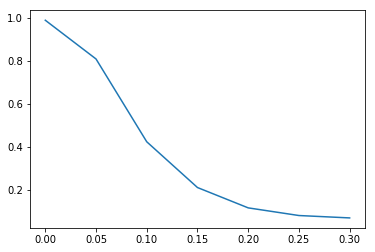

In [19]:
print(accuracies)
plt.plot(epsilons, accuracies)
plt.show()